---
arrival_airport: TBPB
categories: [ec_under, ec_track, c_north, c_mid, pace_under, meteor]
crew:
- job: PI
  name: Jakob Deutloff
- job: WALES
  name: 
- job: HAMP
  name: Wei-Ting Hsiao
- job: Dropsondes
  name: 
- job: Smart/VELOX
  name: 
- job: SpecMACS
  name: 
- job: Flight Documentation
  name: Tristan 
- job: Ground contact
  name: 
departure_airport: TBPB
flight_id: HALO-20240926a
jupytext:
  text_representation:
    extension: .md
    format_name: myst
kernelspec:
  display_name: Python 3 (ipykernel)
  language: python
  name: python3
orphan: true
platform: HALO
takeoff: '2024-09-26 10:33:00Z'
landing: '2024-09-26 19:33:00Z'
---


{logo}`PERCUSION`

# Flight plan - {front}`flight_id`

```{badges}
```

## Crew

```{crew}
```

## Flight plan

In [58]:
# Define HALO flight and crew
from datetime import datetime

aircraft = "HALO"
flight_time = datetime(2024, 9, 26, 11, 48)
flight_id = f"{aircraft}-{flight_time.strftime('%Y%m%d')}a"
crew = {
    "Mission PI": "Jakob Deutloff",
    "DropSondes": "Nina Robbins",
    "HAMP": "Wei-Ting Hsiao",
    "SMART/VELOX": "Patrizia Schoch",
    "SpecMACS": "Tobias Zinner",
    "WALES": "Konstantin Krueger",
    "Flight Documentation": "Tristan Vostry",
    "Ground Support": "Daniel Rowe",
}

In [66]:
# Load forecasts
import easygems.healpix as egh
import intake
import numpy as np
import orcestra.sat
from orcestra.flightplan import tbpb

sat_fcst_date = "2024-09-24"  # date to get satelite forecast(s) from
ifs_fcst_time = "2024-09-25"  # date to get IFS forecast(s) from
ifs_fcst_time = np.datetime64(ifs_fcst_time + "T00:00:00")


# Load satellite track
print(
    f"SATELITE TRACK FORECAST FROM: {sat_fcst_date} FOR FLIGHT DAY: {flight_time:%Y-%m-%d}"
)
ec_track = orcestra.sat.SattrackLoader(
    "EARTHCARE", sat_fcst_date, kind="PRE", roi="BARBADOS"
).get_track_for_day(f"{flight_time:%Y-%m-%d}")
ec_track = ec_track.sel(time=slice(f"{flight_time:%Y-%m-%d} 07:00", None))
ec_lons, ec_lats = ec_track.lon.values, ec_track.lat.values

# Load IFS forecast
cat = "https://tcodata.mpimet.mpg.de/internal.yaml"
ifs_ds = (
    intake.open_catalog(cat)
    .HIFS(datetime=ifs_fcst_time)
    .to_dask()
    .pipe(egh.attach_coords)
)

SATELITE TRACK FORECAST FROM: 2024-09-24 FOR FLIGHT DAY: 2024-09-26


In [67]:
# Create Points of flight plan
from orcestra.flightplan import (
    LatLon,
    FlightPlan,
    point_on_track,
    IntoCircle,
)

radius = 72e3 * 1.852 # Mass flux circle radius (m)
speed_halo = 240  # m/s

# Circles
lat_south = 10.5
mid_south = point_on_track(ec_track, lat_south).assign(fl=450, label="c_south")

lat_north = 16.5
mid_north = point_on_track(ec_track, lat_north).assign(fl=450, label="c_north")

mid_mid = mid_south.towards(mid_north, 0.5).assign(label="c_mid", fl=410)

lat_neast = 14
lon_neast = mid_mid.lon + 3.5
mid_neast = LatLon(lat_neast, lon_neast, fl=430, label="c_northeast")

lat_seast = 11
lon_seast = mid_mid.lon + 2.3 + ((5 * 60 * speed_halo) / 110e3)
mid_seast = LatLon(lat_seast, lon_seast, fl=450, label="c_southeast")

# Ec points
ec_south = point_on_track(ec_track, lat=mid_south.lat - 1.2).assign(
    label="ec_south", fl=450
)
ec_north = point_on_track(ec_track, lat=mid_north.lat + 1.2).assign(
    label="ec_north", fl=450
)
ec_under = point_on_track(
    ec_track, lat=(ec_north.lat + ec_south.lat) / 2, with_time=True
).assign(label="ec_under", fl=450, note="Meet EarthCARE")

In [68]:
# Create plan 
waypoints = [
    tbpb,
    IntoCircle(mid_mid, radius=radius, enter=-90, angle=-360),
    IntoCircle(mid_neast, radius=radius, enter=-90, angle=-360),
    IntoCircle(mid_seast, radius=radius, enter=180, angle=-360),
    IntoCircle(mid_south, radius=radius, enter=0, angle=420),
    ec_south,
    ec_under,
    ec_north,
    IntoCircle(mid_north, radius=radius, angle=-420),
    tbpb,
]

extra_waypoints = []

# FlightPlan and print short statement
plan = FlightPlan(
    path=waypoints,
    flight_id=flight_id,
    extra_waypoints=extra_waypoints,
    crew=crew,
    aircraft=aircraft,
)

msg = (
    f"Flight ID: {plan.flight_id}\n"
    + f"Take-off: {plan.takeoff_time:%H:%M %Z}\n"
    + f"Landing:  {plan.landing_time:%H:%M %Z}\n"
    + f"Duration: {plan.duration}"
)
print(msg)

Flight ID: HALO-20240926a
Take-off: 11:48 UTC
Landing:  20:21 UTC
Duration: 8:32:41.595564


(<Figure size 1400x800 with 1 Axes>,
 <GeoAxes: title={'center': '2024-09-26 12:51:00\n\n(CWV forecasted on 2024-09-25 00:00:00)'}>)

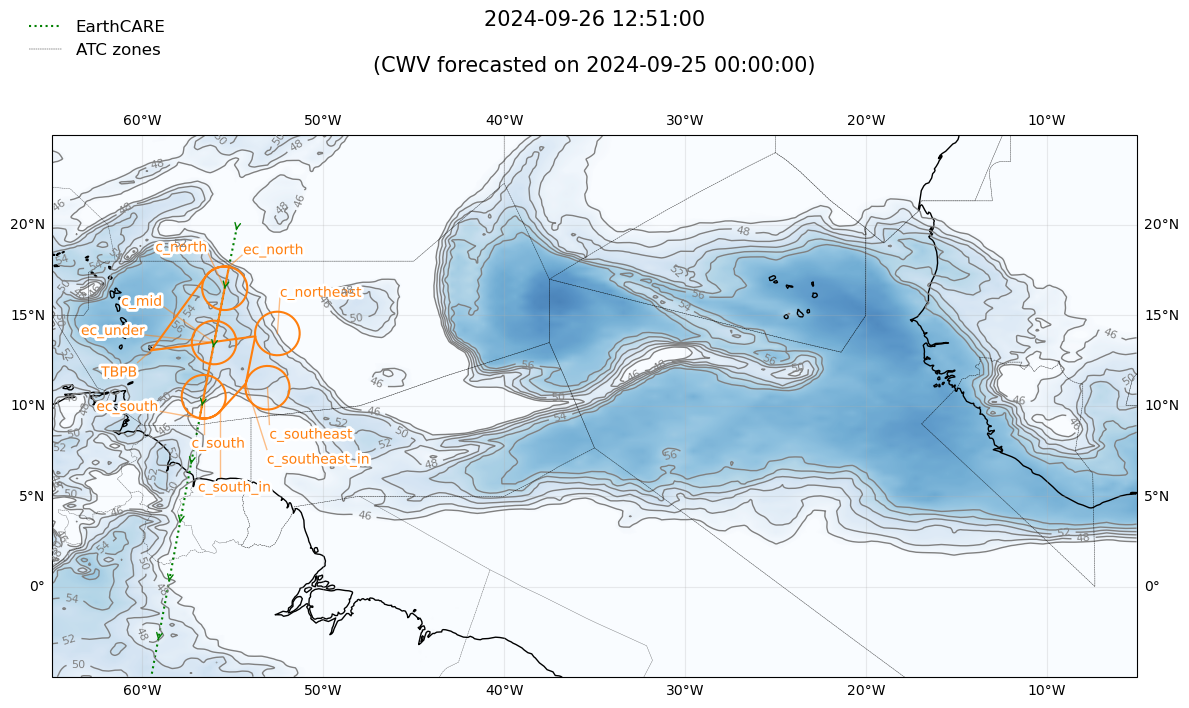

In [69]:
# Plot CVW forecast
from HALO_20240919a_plan import plot_flight_plan_satellite_forecast
from orcestra.flightplan import plot_cwv

figsize = (14, 8)
lon_min, lon_max, lat_min, lat_max = -65, -5, -5, 25
domain_lonlat = [lon_min, lon_max, lat_min, lat_max]


def plot_ifs_cwv_forecast(fig, ax, ifs_ds, flight_time, levels=None):
    cwv_flight_time = ifs_ds["tcwv"].sel(time=flight_time, method="nearest")
    plot_cwv(cwv_flight_time, ax=ax, levels=levels)


plot_cwv_kwargs = {"flight_time": flight_time, "levels": [46, 48, 50, 52, 54, 56]}


plot_flight_plan_satellite_forecast(
    figsize,
    flight_time,
    plan,
    domain_lonlat,
    is_ec_track=True,
    ec_track=ec_track,
    is_pace_track=False,
    pace_track=None,
    forecast_overlay=True,
    ifs_ds=ifs_ds,
    ifs_fcst_time=ifs_fcst_time,
    forecast_title_label="CWV",
    plot_forecast_func=plot_ifs_cwv_forecast,
    plot_forecast_kwargs=plot_cwv_kwargs,
    atc_zones=True,
    worldfirs_json="worldfirs.json",
    is_meteor=False,
)

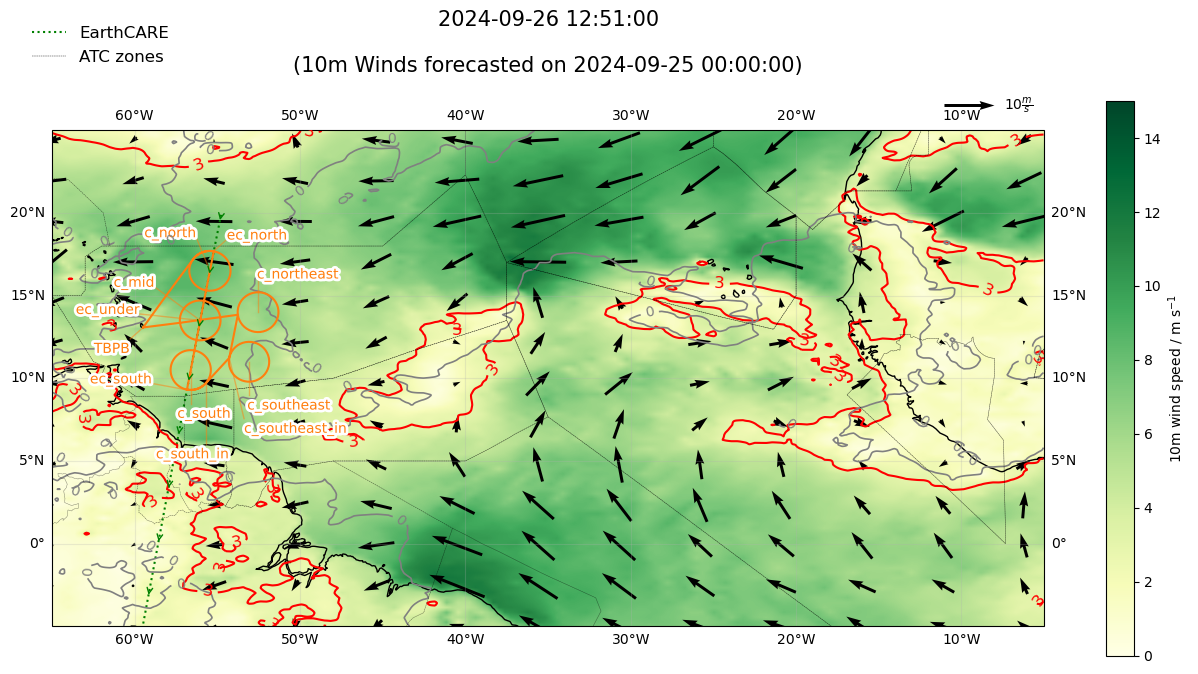

In [70]:
# Plot 10m winds forecast
import HALO_20240919a_sfc_winds as sfc_winds

figsize = (16, 9)


def plot_ifs_sfc_winds_forecast(fig, ax, ifs_ds, domain_lonlat, flight_time):
    u10m = ifs_ds["10u"].sel(time=flight_time, method="nearest")
    v10m = ifs_ds["10v"].sel(time=flight_time, method="nearest")
    windspeed_10m = np.sqrt(u10m**2 + v10m**2)
    sfc_winds._windspeed_plot(windspeed_10m, fig, ax)
    sfc_winds._wind_direction_plot(u10m, v10m, ax, domain_lonlat)
    sfc_winds._windspeed_contour(windspeed_10m, ax)
    sfc_winds._draw_confluence_contour(v10m, ax)


plot_ifs_sfc_winds_kwargs = {
    "domain_lonlat": domain_lonlat,
    "flight_time": flight_time,
}

fig, ax = plot_flight_plan_satellite_forecast(
    figsize,
    flight_time,
    plan,
    domain_lonlat,
    is_ec_track=True,
    ec_track=ec_track,
    is_pace_track=False,
    pace_track=None,
    forecast_overlay=True,
    ifs_ds=ifs_ds,
    ifs_fcst_time=ifs_fcst_time,
    forecast_title_label="10m Winds",
    plot_forecast_func=plot_ifs_sfc_winds_forecast,
    plot_forecast_kwargs=plot_ifs_sfc_winds_kwargs,
    atc_zones=True,
    worldfirs_json="worldfirs.json",
    is_meteor=False,
)

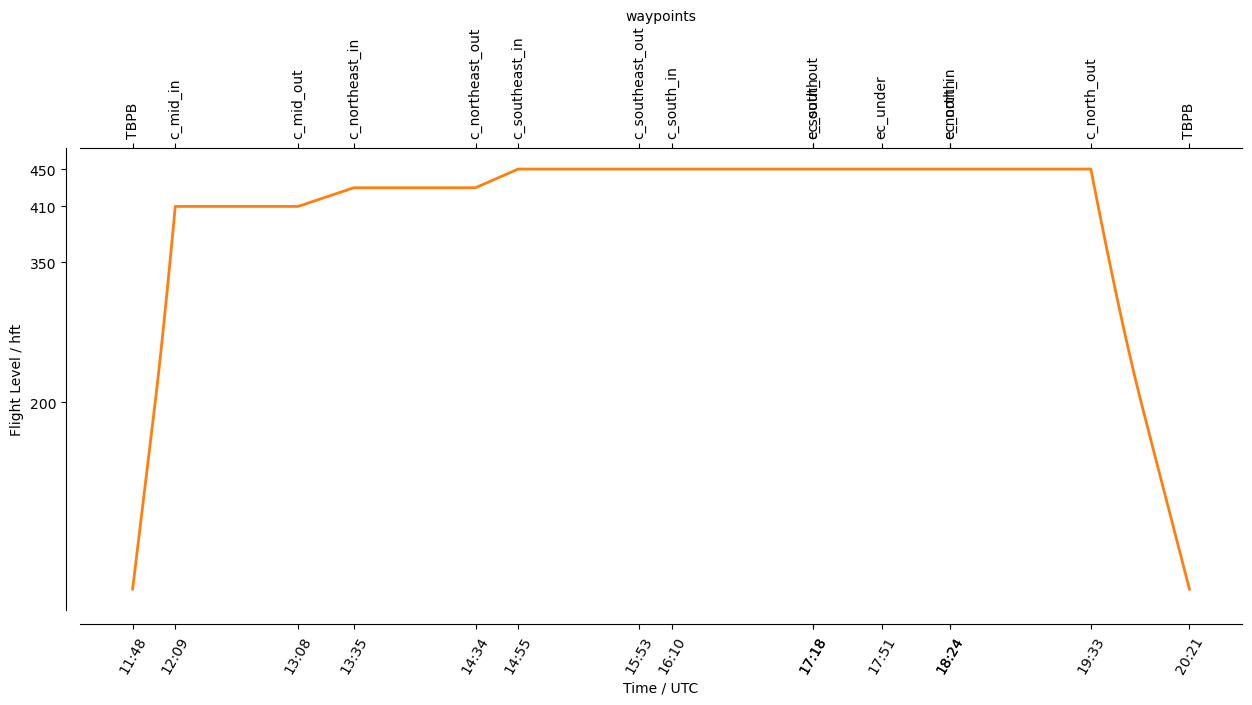

In [71]:
from orcestra.flightplan import vertical_preview

vertical_preview(waypoints)

In [72]:
plan.show_details()
plan.export()

Detailed Overview:
              TBPB         N13 04.48, W059 29.55, FL000, 11:48:25 UTC, 
circle around c_mid        N13 30.06, W056 02.48, FL410, 12:09:07 UTC - 13:08:40 UTC, radius: 72 nm, 360° CCW, enter from west
circle around c_northeast  N14 00.00, W052 32.48, FL430, 13:35:45 UTC - 14:34:46 UTC, radius: 72 nm, 360° CCW, enter from west
to (helper)   c_southeast_in N11 13.97, W054 17.06, FL450, 14:55:24 UTC, upcoming circle will be entered here
circle around c_southeast  N11 00.00, W053 05.21, FL450, 14:55:24 UTC - 15:53:57 UTC, radius: 72 nm, 360° CCW, enter from west
to (helper)   c_south_in   N09 41.31, W055 42.89, FL450, 16:10:09 UTC, upcoming circle will be entered here
circle around c_south      N10 30.00, W056 36.87, FL450, 16:10:09 UTC - 17:18:27 UTC, radius: 72 nm, 420° CW, enter from south east
to            ec_south     N09 18.00, W056 50.55, FL450, 17:18:43 UTC, 
to            ec_under     N13 30.00, W056 02.34, FL450, 17:51:46 UTC, Meet EarthCARE
to            ec_nor

HTML(value='<html>\n    <head>\n    <meta name="viewport" content="width=device-width, initial-scale=1">\n    …